# Market Risk Project

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

# Overview of the data

import of the used dataset, with function selecting the right timescale

        Date  Price
0 2015-01-02  5.621
1 2015-01-05  5.424
2 2015-01-06  5.329
3 2015-01-07  5.224
4 2015-01-08  5.453
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1023 non-null   datetime64[ns]
 1   Price   1023 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.1 KB
None


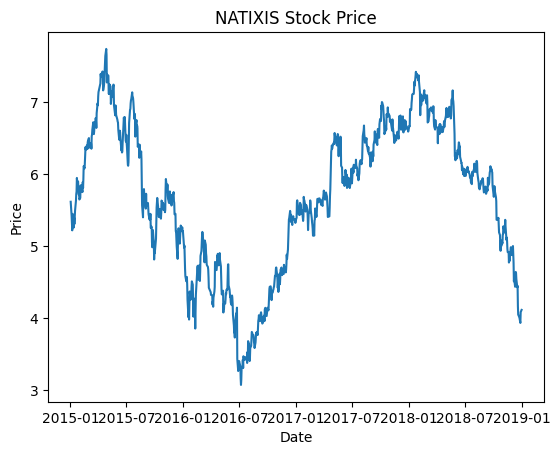

In [ ]:
df = pd.read_csv("NATIXIS STOCK.txt", delimiter='\t', header=None, names=["Date", "Price"])

def adjust_price(price):
    price = price.replace(',', '.')
    if '.' in price:
        parts = price.split('.')
        if len(parts[1]) == 1:
            price += '00'
        elif len(parts[1]) == 2:
            price += '0'
    return float(price)

df['Price'] = df['Price'].apply(adjust_price)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

print(df.head())
print(df.info())

plt.plot(df['Date'], df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('NATIXIS Stock Price')
plt.show()


        Date  Price    Return
1 2015-01-05  5.424 -3.504714
2 2015-01-06  5.329 -1.751475
3 2015-01-07  5.224 -1.970351
4 2015-01-08  5.453  4.383614
5 2015-01-09  5.340 -2.072254


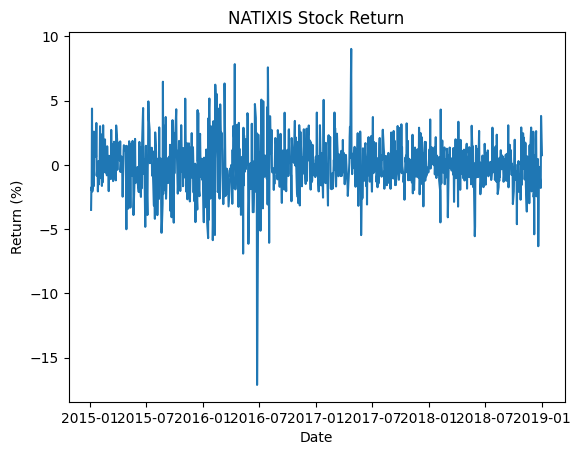

In [ ]:
#we also compute the return of the stock and add the column in the dataset
df['Return'] = df['Price'].pct_change() * 100
df.dropna(inplace=True)
print(df.head())

plt.plot(df['Date'], df['Return'])
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.title('NATIXIS Stock Return')
plt.show()

# Non-parametric VaR and threshold exceedence

**part a**

We estimate a historical VaR on price returns at a one-day horizon for a given
probability level (this probability is a parameter which must be changed easily). We based our
VaR on a non-parametric distribution (logistic Kernel, that is 𝐾 is the derivative of the logistic function x ↦1/(1+𝑒(-x))

In [ ]:
# in this part we need to use the daily prices of the stock Natixis between January 2015 and December 2016
dfa = df[(df['Date'] >= '2015-01-01') & (df['Date'] <= '2016-12-31')]
dfa.head()

,Date,Price,Return
1,2015-01-05,5.424,-3.504714
2,2015-01-06,5.329,-1.751475
3,2015-01-07,5.224,-1.970351
4,2015-01-08,5.453,4.383614
5,2015-01-09,5.340,-2.072254


<ipython-input-431-52dd87a3363d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa["Estimated CDF"] = dfa["Return"].apply(lambda x: F(x, dfa["Return"], h))


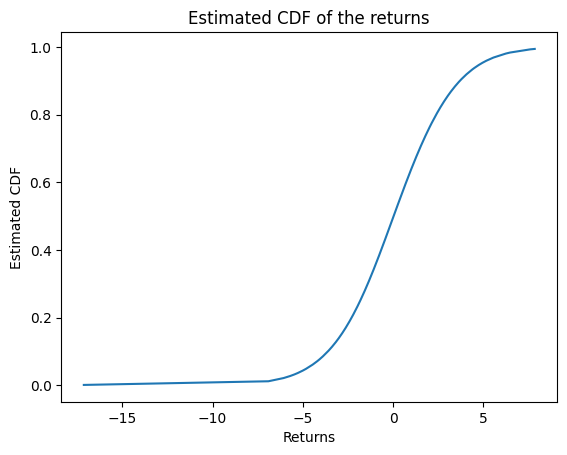

In [ ]:
# we estimate the CDF of the returns using the CDF of the kernel density which is x ↦1/(1+𝑒(-x))
#we first define the kernel function
def K(x):
    return 1 / (1 + np.exp(-x))

#we then define the kernel-based CDF estimator
def F(x, data, h):
    return np.mean(K((x - data) / h))

#smoothing parameter (bandwidth)
h = 1

#finally we compute the Estimated CDF for all returns in a vectorized manner
dfa["Estimated CDF"] = dfa["Return"].apply(lambda x: F(x, dfa["Return"], h))

#now we want to plot the estimated CDF, for that we sort the returns to plot it correclty
dfa_sorted = dfa.sort_values(by="Return")
plt.plot(dfa_sorted["Return"], dfa_sorted["Estimated CDF"])
plt.xlabel("Returns")
plt.ylabel("Estimated CDF")
plt.title("Estimated CDF of the returns")
plt.show()

In [ ]:
#we now want to compute the Value at Risk for different probability levels, we assume here that our returns are gains and for alpha close to 1 we have
#recall that we look for a value of return x such as F(x)>=1-alpha

#we define first a function to compute the VaR
def VaR_kernel(cdf, returns, alpha):
    for i in range(len(returns)):
        if cdf[i] >= 1 - alpha:
            return returns[i]
    return None

# Sort returns and CDF for monotonicity
sorted_returns = dfa_sorted["Return"].values
sorted_cdf = dfa_sorted["Estimated CDF"].values

# Compute VaR for various alpha levels
alphas = [0.99, 0.95, 0.90, 0.85]
vars = {alpha: VaR_kernel(sorted_cdf, sorted_returns, alpha) for alpha in alphas}

print("Value at Risk (VaR) for various confidence levels using a kernel estimated CDF:")
for alpha, var in vars.items():
    print(f"VaR at {alpha*100:.0f}% confidence level: {var:.4f}")


Value at Risk (VaR) for various confidence levels using a kernel estimated CDF:
VaR at 99% confidence level: -6.9083
VaR at 95% confidence level: -4.5485
VaR at 90% confidence level: -3.5760
VaR at 85% confidence level: -2.8452


The Value at Risk (VaR) estimates the potential loss for various confidence levels, with a 99% confidence level indicating a loss of -6.9083, 95% at -4.5485, 90% at -3.5760, and 85% at -2.8452, using a kernel estimated cumulative distribution function (CDF).

We now want to know the proportion of price returns between January 2017 and December 2018 that exceed the VaR threshold defined in the previous question

In [ ]:
# in this part we need to use the daily prices of the stock Natixis between January 2017 and December 2018
dfb = df[(df['Date'] >= '2017-01-01') & (df['Date'] <= '2018-12-31')]
print(dfb.head())

          Date  Price    Return
513 2017-01-02  5.400  0.746269
514 2017-01-03  5.620  4.074074
515 2017-01-04  5.641  0.373665
516 2017-01-05  5.595 -0.815458
517 2017-01-06  5.563 -0.571939


In [ ]:
#we create a dictionnary containing the values obtained for different probability levels during the previous step
VaR_thresholds = {'99%': -6.9083, '95%': -4.5485, '90%': -3.5760,'85%': -2.8452}

#we define a function to calculate the proportion of returns exceeding the VaR threshold
def proportion(returns, VaR_threshold):
    exceeding = np.sum(returns < VaR_threshold)
    proportion = exceeding/ len(returns)
    return proportion

#we now apply our function to each VaR threshold
proportions = {alpha: proportion(dfb['Return'], VaR) for alpha, VaR in VaR_thresholds.items()}

# Print the results
for alpha, proportion in proportions.items():
    print(f"Proportion of returns exceeding the VaR at {alpha} confidence level: {proportion:.4f}")

Proportion of returns exceeding the VaR at 99% confidence level: 0.0000
Proportion of returns exceeding the VaR at 95% confidence level: 0.0118
Proportion of returns exceeding the VaR at 90% confidence level: 0.0176
Proportion of returns exceeding the VaR at 85% confidence level: 0.0353


The fact that the proportion of returns exceeding the VaR at the 99% confidence level is very low might suggest that the VaR is overly conservative or the kernel is not capturing extreme market events adequately.

However, the low exceedance proportion can also indicate that the model is correctly identifying the "normal" range of returns and avoiding overestimation of risk. The 95%, 90%, and 85% levels show small but positive proportions of exceedances, which is a reasonable outcome for a VaR model, suggesting that extreme but plausible market conditions were captured.

If the purpose is to avoid underestimating risk in the tail of the distribution, the choice of a non-parametric VaR based on the logistic kernel could still be valid, but adjustments (e.g., kernel parameters, bandwidth) might be needed to better capture extreme events.

The non-parametric VaR seems reasonable, but it may require further refinement or validation to ensure it captures extreme market events more accurately, especially at the higher confidence levels (like 99%).

# Monte-Carlo VaR
We want to calculate the VaR (on the arithmetic variation of price, at a *one-day horizon*) for a *call option* on the Natixis stock. We are going to implement a Monte-Carlo VaR since the call price is a non-linear
function of the underlying price, that we are able to model thanks to historical data.

first we estimate the parameters of a standard Brownian motion on the Natixis stock between 2015 and 2018, using an exponential weighting of the data. In this part we choose to work with the log returns to estimate the parameters

In [ ]:
#get the asked historical data
dfB = df[(df['Date'] >= '2015-01-01') & (df['Date'] <= '2018-12-31')]
dfB['Log Return'] = np.log(dfB['Price'] / dfB['Price'].shift(1))

#first we set the decay factor for the exponentially weighted moving average
lambda_ewma= 0.94

#we calculate the EWMA of the squared returns for volatility estimation
dfB['Log Return squared'] = dfB['Log Return'] ** 2
dfB['EWMA volatility'] = dfB['Log Return squared'].ewm(span=(2 / (1 - lambda_ewma)) - 1, adjust=False).mean() ** 0.5

#we then estimate the drift as the average return over the period
drift_estimate = dfB['Log Return'].mean()
print(f"Drift Estimate: {drift_estimate}")

#and we estimate the volatility as the average of the exponentially weighted moving average volatility
volatility_estimate = dfB['EWMA volatility'].iloc[-1]
print(f"Volatility Estimate: {volatility_estimate}")

Drift Estimate: -0.0002695623263311943
Volatility Estimate: 0.024546306321711103


We now simulate a number N (say N=1000) of prices of the stock in a one-day horizon (we are working at the last date of 2018).

We simulate future stock prices for the next day using the formula for geometric Brownian motion (we use the estimated drift μ and volatility σ).

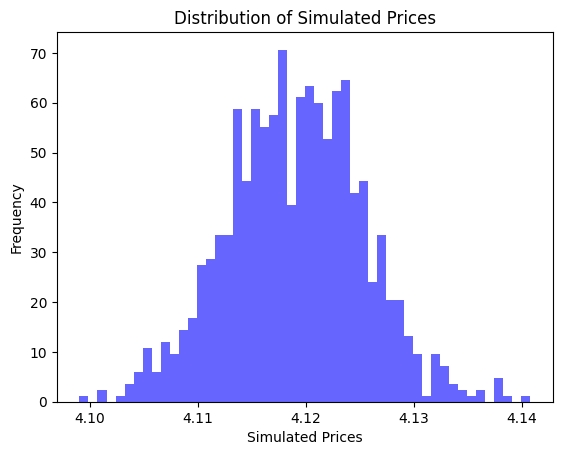

In [ ]:
N = 1000
S0 = dfB['Price'].iloc[-1]
mu = drift_estimate
sigma = volatility_estimate
T1day = 1 / 252

#here we create a list containing all the simulated prices at a one day time horizon
simulated_prices_1day = np.zeros(N)
for i in range(N):
    Z = np.random.normal(0, 1)
    S_T = S0 * np.exp((mu - 0.5 * sigma**2) * T1day + sigma * np.sqrt(T1day) * Z)
    simulated_prices_1day[i] = S_T

#we plot the simulated prices for better analysis
plt.hist(simulated_prices_1day, bins=50, density=True, alpha=0.6, color='b')
plt.xlabel('Simulated Prices')
plt.ylabel('Frequency')
plt.title('Distribution of Simulated Prices')
plt.show()

We then transform each of these prices of underlying in prices of the corresponding call (at the money, with one-month maturity and 0 risk-free rate and dividend).

To estimate Call Prices with 1-Month Maturity we use the simulated stock prices.
For each simulated 1-day stock price we calculate the 1-month call option price using the Black-Scholes formula.

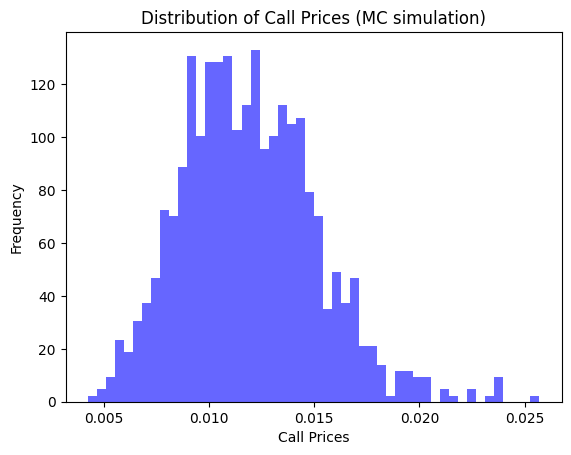

In [ ]:
#since it is at the money the strike K is equal to S0 stock price at the last date of 2018
#we created a list containing all the call prices
N = 1000
S0 = dfB['Price'].iloc[-1]
mu = drift_estimate
sigma = volatility_estimate
T1month = 1 / 12
K = S0
r = 0.0

call_prices = np.zeros(N)
for i in range(N):
    S_T = simulated_prices_1day[i]
    d1 = (np.log(S_T / K) + (r + 0.5 * sigma**2) * T1month) / (sigma * np.sqrt(T1month))
    d2 = d1 - sigma * np.sqrt(T1month)
    call_prices[i] = S_T * norm.cdf(d1) - K * np.exp(-r * T1month) * norm.cdf(d2)

plt.hist(call_prices, bins=50, density=True, alpha=0.6, color='b')
plt.xlabel('Call Prices')
plt.ylabel('Frequency')
plt.title('Distribution of Call Prices (MC simulation)')
plt.show()

And finally we pick the empirical quantile of these N call prices to build the VaR of the call.

In [ ]:
#we then take the 5% quantile of the simulated call option prices to estimate the 95% Value at Risk (VaR)
VaR_95 = np.percentile(call_prices, 5)
print(f"95% VaR for the call option: {VaR_95:.10f}")

95% VaR for the call option: 0.0071567002


# EVT and Extremal Index
With the dataset on Natixis prices, used previously.
We are going to analyse these returns using a specific method in the field of the EVT.

In [ ]:
print(df.head())

        Date  Price    Return
1 2015-01-05  5.424 -3.504714
2 2015-01-06  5.329 -1.751475
3 2015-01-07  5.224 -1.970351
4 2015-01-08  5.453  4.383614
5 2015-01-09  5.340 -2.072254


 We are going to estimate the GEV parameters for the two tails of the distribution of returns, using the estimator of
Pickands

In [ ]:
#to simplify the computation, we create a new list containing sorted returns
returns = df['Return'].dropna().sort_values(ascending=True)
n =int(len(returns))
#we set here k(n)=sqrt(n) but we could have also use log, you can easily change it
k = int(np.sqrt(n))


X_k_upper = returns.iloc[n-k+1]
X_2k_upper = returns.iloc[n-2*k+1]
X_4k_upper = returns.iloc[n-4*k+1]
pickands_upper = (1/np.log(2)) * (np.log(X_k_upper - X_2k_upper/ X_2k_upper-X_4k_upper))


returns_neg = -returns[::-1]

X_k_lower = returns_neg.iloc[n-k+1]
X_2k_lower = returns_neg.iloc[n-2*k+1]
X_4k_lower = returns_neg.iloc[n-4*k+1]
pickands_lower = (1/np.log(2)) * (np.log(X_k_lower - X_2k_lower/ X_2k_lower - X_4k_lower))


print(f"Pickands Estimator for Upper Tail (ξ_upper): {pickands_upper}")
print(f"Pickands Estimator for Lower Tail (ξ_lower): {pickands_lower}")

Pickands Estimator for Upper Tail (ξ_upper): -0.28777278535735623
Pickands Estimator for Lower Tail (ξ_lower): 0.133604027571788


The Pickands estimators indicate asymmetry in extreme gains and losses:

Upper Tail (𝜉upper)=−0.288
Negative value means gains are bounded, so there’s a limit to extreme positive outcomes.

Lower Tail (𝜉lower)=0.134
Positive value suggests losses are heavy-tailed and unbounded, allowing for potentially large negative outcomes.

Extreme losses are riskier and unbounded, while gains are limited. This highlights the need for cautious profit projections and robust risk management.

We now determine the extremal index using the block and the run de-clustering

In [ ]:
import builtins
#block declustering
def extremal_index_block(data, threshold, block_size):
    n = len(data)
    num_blocks = n // block_size
    block_extremes = [np.max(data["Return"][i * block_size : (i + 1) * block_size]) for i in range(num_blocks)]
    num_clusters = builtins.sum(1 for x in block_extremes if x > threshold)
    num_extremes = builtins.sum(1 for x in data["Return"] if x > threshold)

    theta_block = num_clusters / num_extremes if num_extremes > 0 else 0
    return theta_block


#run declustering
def extremal_index_run(data, threshold, run_size):
    n = len(data)
    num_extremes = builtins.sum(1 for x in data["Return"] if x > threshold)
    clusters = 0
    i = 0
    while i < n:
        if data["Return"].iloc[i] > threshold:
            clusters += 1
            i += run_size
        else:
            i += 1
    theta_run = clusters / num_extremes if num_extremes > 0 else 0
    return theta_run

#we can now set the threshold, the block size and the run size to finally compute the extremal indexs and compare them
threshold=3
block_size=5
run_size=5


theta_block = extremal_index_block(df, threshold, block_size)
theta_run = extremal_index_run(df, threshold, run_size)


print(f"Extremal Index (Block Declustering): {theta_block}")
print(f"Extremal Index (Run Declustering): {theta_run}")

Extremal Index (Block Declustering): 0.8225806451612904
Extremal Index (Run Declustering): 0.7419354838709677


Using a threshold of 3, block size of 5, and run size of 5, the extremal index was computed as:

Block Declustering: 0.8226

Run Declustering: 0.7419

Block Declustering suggests slightly less clustering of extremes than Run Declustering. The choice of method depends on the dataset and analysis goals, with results influenced by parameter selection.

An extremal index (𝜃) of 0.8226 from Block Declustering means that approximately 82.26% of extreme values (those exceeding the threshold) are part of distinct clusters, with the remaining 17.74% likely grouped together in clusters of extremes.

A value close to 1 suggests lower clustering of extremes, indicating that extreme events occur more independently within the analyzed blocks. So here we can say that the extremes price returns are really weakly dependent.

# Liquidation strategy using Almgren and Chriss
In this part we will use an other dataset
Our goal here is to estimate all the parameters of the model of Almgren and Chriss and implement a liquidation strategy.


In [ ]:
data = pd.read_excel("Dataset TD4.xlsx")
#print(data.head())


We want to estimate all the parameters of the model of Almgren and Chriss, since it is a parametric model depending on permananent and transient impact

We need to estimate the volatility, gamma the coefficient in the permanenet impact function and eta the coefficient in the transient impact function

In [ ]:
#first we want to estimate the volatility, for that we need to compute the returns rt = ((Pt+1-Pt)/Pt) * (1/sqrt(time_step))
def compute_returns(data):
    prices = data['Price (before transaction)']
    time_steps = data['transaction date (1=1day=24 hours)'].diff()

    returns = ((prices.diff()) / prices.shift(1)) * (1 / np.sqrt(time_steps))
    returns[(time_steps <= 0) | (prices.shift(1) == 0)] = np.nan

    data['Returns'] = returns
    return data

data=compute_returns(data)


#we can gfinally compute the volatility
mean_returns = data['Returns'].mean()
sum_diff = 0
sum = 0
for returns in data['Returns'] :
  if not np.isnan(returns):
    sum_diff += (returns-mean_returns) **2
    sum += 1

sigma = (sum_diff / (sum - 1))**0.5
sigma_annualized=round(sigma*np.sqrt(24)*np.sqrt(252),4)

print("sigma :", sigma)
print("sigma annualized :", sigma_annualized)

sigma : 0.06717736752097081
sigma annualized : 5.2243


In [ ]:
#we want now to estimate the parameter of the permanent impact function g(v)=gamma*v with v liquidation speed
#we know that gamma can by estimated by conducting a linear regression, taking account that g(v(t))= P(t+2)-P(t)=gamma*v(t)
# we create a column P(t+2)-P(t), and a column containing the liquidation speed

def prepare_gamma_estimation(data):
    data['P(t+2) - P(t)'] = data['Price (before transaction)'].shift(-2) - data['Price (before transaction)']
    data['time_step'] = data['transaction date (1=1day=24 hours)'].diff()
    data['v(t)'] = data['volume of the transaction (if known)'] / data['time_step']
    data_clean = data.dropna(subset=['P(t+2) - P(t)', 'v(t)'])
    return data_clean

data_clean = prepare_gamma_estimation(data)

# Filter outliers for both metrics
def filter_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

data_filtered = data_clean.pipe(filter_outliers, 'P(t+2) - P(t)')
data_filtered = data_filtered.pipe(filter_outliers, 'v(t)')

<ipython-input-445-d938dede477b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['log_v'] = np.log1p(data_clean['v(t)'])


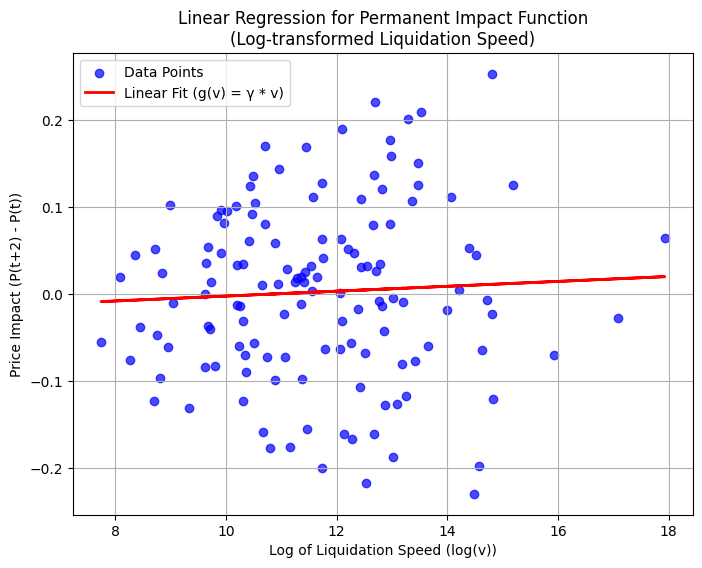

Mean Squared Error (MSE): 0.010040242388833765
R-squared (R2): 0.002742143362083338
new estimated gamma: 0.0028113027323688968


In [ ]:
#we decided to improve our linear regression because as you can see the results where terrible
#so we decided to apply log transform to the liquidation speed to handle the scale issues & we also remove the outliers using IQR method
data_clean['log_v'] = np.log1p(data_clean['v(t)'])

Q1 = data_clean['P(t+2) - P(t)'].quantile(0.25)
Q3 = data_clean['P(t+2) - P(t)'].quantile(0.75)
IQR = Q3 - Q1
data_filtered = data_clean[
    (data_clean['P(t+2) - P(t)'] >= Q1 - 1.5 * IQR) &
    (data_clean['P(t+2) - P(t)'] <= Q3 + 1.5 * IQR)
]

from sklearn.metrics import mean_squared_error, r2_score

X = data_filtered[['log_v']].values
y = data_filtered['P(t+2) - P(t)'].values

model = LinearRegression()
model.fit(X, y)

predictions_linear = model.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(data_filtered['log_v'], data_filtered['P(t+2) - P(t)'], color='blue', alpha=0.7, label='Data Points')
plt.plot(data_filtered['log_v'], predictions_linear, color='red', linewidth=2, label='Linear Fit (g(v) = γ * v)')
plt.title('Linear Regression for Permanent Impact Function\n(Log-transformed Liquidation Speed)')
plt.xlabel('Log of Liquidation Speed (log(v))')
plt.ylabel('Price Impact (P(t+2) - P(t))')
plt.legend()
plt.grid()
plt.show()

mse = mean_squared_error(y, predictions_linear)
r2 = r2_score(y, predictions_linear)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


gamma= model.coef_[0]
print("new estimated gamma:", gamma)


In [ ]:
#we clean our data set for the next estimation of the transient impact parametr eta
data_clean = data_clean.drop(columns=['P(t+2) - P(t)', 'log_v', 'Returns'])

<ipython-input-447-4eeeafaac62c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['log_v'] = np.log1p(data_cleaned['v(t)'])


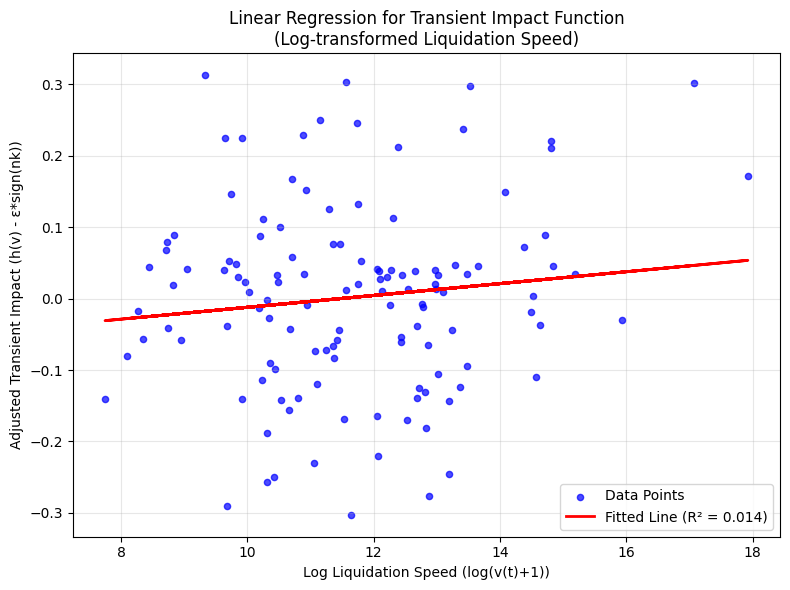

Mean Squared Error (MSE): 0.01700964172220278
R-squared (R2): 0.01416211754068275
Estimated η (coefficient): 0.008299


In [ ]:
#we are now going to conduct a new linear regression to estimate the transient impact parameter eta knowing that h(vk)= epsilon*sign(nk) + eta*(nk/tau)
#we have that the transient impact h(nk/tau)=P(t+2)-P(t+1) so we can carry out a linear regression of h(nk/tau)-epsilon*sign(nk) with respect to (nk/tau)=vk
#we create the necessary column, lets recall that epsilon is the bid-ask spread
#since we also got a bad raw linear regression, we dicided to work with the log liquidation speed and remove outliers using interquantile
data_clean['P(t+2) - P(t+1)'] = data_clean['Price (before transaction)'].shift(-1) - data_clean['Price (before transaction)'] #h(nk/tau)
data_clean['adjusted_h'] = data_clean['P(t+2) - P(t+1)'] - (data_clean['bid-ask spread'] * data_clean['Sign of the transaction'])

data_filtered = data_clean.dropna(subset=['adjusted_h', 'v(t)'])

Q1 = data_filtered['adjusted_h'].quantile(0.25)
Q3 = data_filtered['adjusted_h'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data_cleaned = data_filtered[(data_filtered['adjusted_h'] >= lower_bound) & (data_filtered['adjusted_h'] <= upper_bound)]

data_cleaned['log_v'] = np.log1p(data_cleaned['v(t)'])

#we can now retry to conduct our linear regression
X = data_cleaned[['log_v']].values
y = data_cleaned['adjusted_h'].values

model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)

mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
eta=model.coef_[0]

plt.figure(figsize=(8, 6))
plt.scatter(data_cleaned['log_v'], data_cleaned['adjusted_h'], color='blue', alpha=0.7, s=20, label='Data Points')
plt.plot(data_cleaned['log_v'], predictions, color='red', linewidth=2, label=f'Fitted Line (R² = {r2:.3f})')
plt.title('Linear Regression for Transient Impact Function\n(Log-transformed Liquidation Speed)')
plt.xlabel('Log Liquidation Speed (log(v(t)+1))')
plt.ylabel('Adjusted Transient Impact (h(v) - ε*sign(nk))')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print(f"Estimated η (coefficient): {model.coef_[0]:.6f}")

To conclude for the estimation of the coefficient part, we obtain better linear regression using the log liquidation speed. Event though we don't have greate results metrics for the permanenet impact coeff gamma and the transient coeff eta.

Estimated gamma : 0.0028113027323688968

Estimated η : 0.008299

The models appear reasonably well-specified for their intended use in optimal execution and market impact modeling, but the low R² and small parameters suggest that there might be room for improvement or further calibration based on real-world data.

In the framework of Almgren and Chriss, we want to implement a liquidation strategy (we recall that we can only make transactions once every hour)

In [ ]:
#we also need to compute the hourly volatility since we will make transactiopn every hour
data_sorted = data_cleaned.sort_values('transaction date (1=1day=24 hours)')
hours = np.arange(0, 25) / 24
hourly_prices = np.interp(hours, data_sorted['transaction date (1=1day=24 hours)'], data_sorted['Price (before transaction)'])

returns = np.diff(hourly_prices) / hourly_prices[:-1]
vol_hour = np.std(returns)
print("Hourly volatility:",vol_hour)

Hourly volatility: 0.004146855438509679


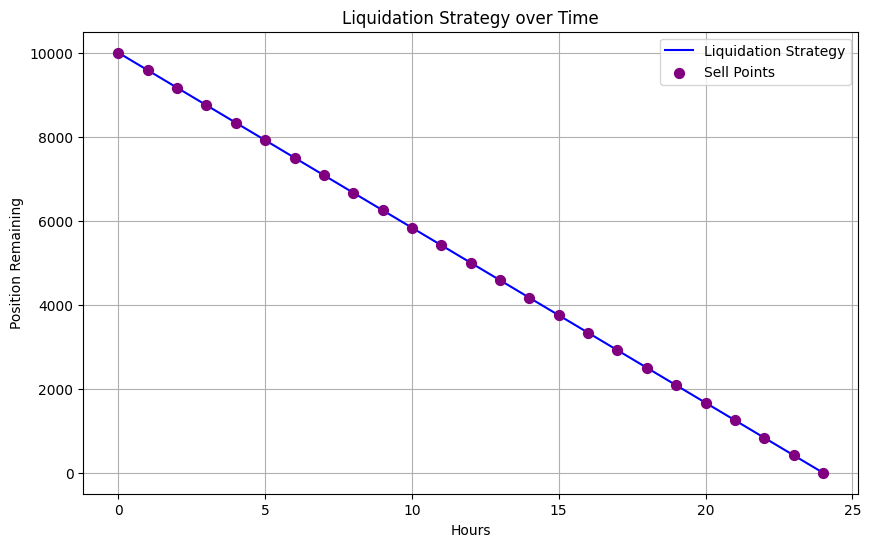

Risk Aversion (γ): 0.0028113027323688968
Variance (vol_hour^2): 1.71964100278973e-05
Eta (η): 0.008299000527999263
T (Total time): 1
X (Initial position): 10000


In [ ]:
#first we define the liquidation function
def liquidation(risk_aversion, variance, eta, T, X):
    K = np.sqrt((risk_aversion * variance) / eta)
    hours = np.arange(0, 25)
    xk = np.zeros(len(hours))
    xk[0] = X
    for i in range(1, len(hours)):
        t = i / 24
        xk[i] = (np.sinh(K * (T - t)) / np.sinh(K * T)) * X
    return xk, hours

#now we can apply the liquidation function to our position using all the estimated coefficients and plot the results
risk_aversion=gamma
eta=eta
variance=vol_hour**2
T=1
X=10000

liquidation_strategy , hours = liquidation(risk_aversion, variance, eta, T, X)

plt.figure(figsize=(10, 6))
plt.plot(hours, liquidation_strategy, label="Liquidation Strategy", color='b')
plt.scatter(hours, liquidation_strategy, color='purple', zorder=5, label="Sell Points", s=50)
plt.title("Liquidation Strategy over Time")
plt.xlabel("Hours")
plt.ylabel("Position Remaining")
plt.grid(True)
plt.legend()
plt.show()


print("Risk Aversion (γ):", risk_aversion)
print("Variance (vol_hour^2):", variance)
print("Eta (η):", eta)
print("T (Total time):", T)
print("X (Initial position):", X)

Our liquidation strategy seem a bit weird because it's a simple straigh line. This is maybe due to errors in the estimation of the coefficient. Both linear regressions conducted to estimate the permanent impact coefficient gamma and the transient impact coefficient eta were not good. The results metrics like the R^2 were really low.

# Haar wavelets and multiresolution correlation

With Haar wavelets and an other dataset provided, we want to determine the multiresolution correlation between all the pairs of FX rates, using GBPEUR, SEKEUR, and CADEUR (we work here with the average between the highest and the lowest price and transform this average price in returns on the smallest time step).

In [ ]:
#first we import the new dataset we are working with, creating a new dataset for each pair
df_currency= pd.read_excel('Dataset TD5.xlsx', header=2)
df_gbpeur = df_currency[['Date', 'HIGH', 'LOW']].copy()
df_sekeur = df_currency[['Date.1', 'HIGH.1', 'LOW.1']].copy()
df_cadeur = df_currency[['Date.2', 'HIGH.2', 'LOW.2']].copy()

#we then create average price columns and create lists for each, because easier to work with
df_gbpeur['MEAN'] = (df_gbpeur['HIGH'] + df_gbpeur['LOW']) / 2
gbpeur_list = df_gbpeur['MEAN'].tolist()
df_sekeur['MEAN.1'] = (df_sekeur['HIGH.1'] + df_sekeur['LOW.1']) / 2
sekeur_list = df_sekeur['MEAN.1'].tolist()
df_cadeur['MEAN.2'] = (df_cadeur['HIGH.2'] + df_cadeur['LOW.2']) / 2
cadeur_list = df_cadeur['MEAN.2'].tolist()

We then define all our wevelets to compute the scalling coefficients

In [ ]:
def mother_wavelet(t):
    if 0 <= t < 0.5:
        return 1
    elif 0.5 <= t < 1:
        return -1
    else:
        return 0

def daughter_wavelet(t, j, k):
    return (2 ** (j / 2)) * mother_wavelet((2 ** j) * t - k)

def father_wavelet(t):
    if 0 <= t <= 1:
        return 1
    else:
        return 0

def son_wavelet(t, j, k):
    scaled_t = (2 ** j) * t - k
    if 0 <= scaled_t <= 1:
        return (2 ** (j / 2)) * father_wavelet(scaled_t)
    return 0

def calcul_scalling_coef(liste, j, k):
    n = len(liste)
    t_values = np.linspace(0, 1, n)
    wavelet_values = np.array([son_wavelet(t, j, k) for t in t_values])
    coef = np.dot(liste, wavelet_values)
    return coef


In [ ]:
#we define the function to compute covariances
#and the function to compute corelation
def covariance(list1, list2, j):
    n = len(list1)
    k_max = n // j
    sum_cov = 0
    for k in range(k_max):
        coef1 = calcul_scalling_coef(list1, j, k)
        coef2 = calcul_scalling_coef(list2, j, k)
        sum_cov += coef1 * coef2
    return sum_cov / k_max


def correlation_matrix(data_lists, timescales):
    n_assets = len(data_lists)
    correlations = {}

    for j in timescales:
        corr_matrix = np.zeros((n_assets, n_assets))

        for i in range(n_assets):
            for k in range(n_assets):
                if i == k:
                    corr_matrix[i, k] = 1
                else:
                    cov = covariance(data_lists[i], data_lists[k], j)
                    var1 = covariance(data_lists[i], data_lists[i], j)
                    var2 = covariance(data_lists[k], data_lists[k], j)

                    if var1 > 0 and var2 > 0:
                        corr_matrix[i, k] = cov / np.sqrt(var1 * var2)
                    else:
                        corr_matrix[i, k] = 0

        correlations[j] = corr_matrix

    return correlations

#Just keep the first 1000 values for faster compiling because too long else
cadeur_list =  cadeur_list[:1000]
gbpeur_list = gbpeur_list[:1000]
sekeur_list = sekeur_list[:1000]

def normalize(data):
    return (data - np.mean(data)) / np.std(data)

gbpeur_list = normalize(gbpeur_list)
sekeur_list = normalize(sekeur_list)
cadeur_list = normalize(cadeur_list)

def pretty_correlation_matrix(data_lists, timescales, asset_names):
    n_assets = len(data_lists)
    correlations = {}

    for j in timescales:
        corr_matrix = np.zeros((n_assets, n_assets))

        for i in range(n_assets):
            for k in range(n_assets):
                if i == k:
                    corr_matrix[i, k] = 1
                else:
                    cov = covariance(data_lists[i], data_lists[k], j)
                    var1 = covariance(data_lists[i], data_lists[i], j)
                    var2 = covariance(data_lists[k], data_lists[k], j)

                    if var1 > 0 and var2 > 0:
                        corr_matrix[i, k] = cov / np.sqrt(var1 * var2)
                    else:
                        corr_matrix[i, k] = 0

        correlations[j] = pd.DataFrame(
            corr_matrix,
            index=asset_names,
            columns=asset_names
        )

    # Print the pretty matrices
    for timescale, matrix in correlations.items():
        print(f"\nCorrelation Matrix (Timescale {timescale}):")
        print(matrix)

    return correlations

# Define asset names for the lists
asset_names = ["GBP/EUR", "SEK/EUR", "CAD/EUR"]

# Compute and display pretty correlation matrices
correlations = pretty_correlation_matrix([gbpeur_list, sekeur_list, cadeur_list], [2, 4, 8], asset_names)


Correlation Matrix (Timescale 2):
          GBP/EUR   SEK/EUR   CAD/EUR
GBP/EUR  1.000000 -0.975432  0.457283
SEK/EUR -0.975432  1.000000 -0.523316
CAD/EUR  0.457283 -0.523316  1.000000

Correlation Matrix (Timescale 4):
          GBP/EUR   SEK/EUR   CAD/EUR
GBP/EUR  1.000000 -0.631567  0.557139
SEK/EUR -0.631567  1.000000  0.009131
CAD/EUR  0.557139  0.009131  1.000000

Correlation Matrix (Timescale 8):
          GBP/EUR   SEK/EUR   CAD/EUR
GBP/EUR  1.000000 -0.317080  0.693011
SEK/EUR -0.317080  1.000000  0.280059
CAD/EUR  0.693011  0.280059  1.000000


The data suggests an Epps effect, where correlation declines with increasing timescale. This can be explained by microstructure noise, asynchronous trading, and the varying impact of different trading strategies at different timescales.

# Husrt exponent

We now compute the Hurst exponent of GBPEUR, SEKEUR, and CADEUR.
We can then determine their annualized volatility using the daily volatility and Hurst exponents.

In [ ]:
def estimator_hurst(liste):
  n = len(liste)
  t = n/2
  M2 = 0
  M2_prime = 0

  for i in range(1,n):
    diff = liste[i]-liste[i-1]
    diff_square = diff**2
    M2 = M2 + diff_square

  for i in range(1,int(t)):
    diff2 = liste[2*i]-liste[2*i-2]
    diff_square2 = diff2**2
    M2_prime = M2_prime + diff_square2
  M2 = M2/n
  M2_prime = M2_prime/t

  return 0.5*np.log2(M2_prime/M2)

In [ ]:
#hurst estimator for each FX rates
df_gbpeur['MEAN'] = (df_gbpeur['HIGH'] + df_gbpeur['LOW']) / 2
gbpeur_list = df_gbpeur['MEAN'].tolist()
df_sekeur['MEAN.1'] = (df_sekeur['HIGH.1'] + df_sekeur['LOW.1']) / 2
sekeur_list = df_sekeur['MEAN.1'].tolist()
df_cadeur['MEAN.2'] = (df_cadeur['HIGH.2'] + df_cadeur['LOW.2']) / 2
cadeur_list = df_cadeur['MEAN.2'].tolist()

gbpeur_hurst = estimator_hurst(gbpeur_list)
print("Hurst exponent for gbp-eur : ", gbpeur_hurst)

sekeur_hurst = estimator_hurst(sekeur_list)
print("Hurst exponent for sek-eur : ",sekeur_hurst)

cadeur_hurst = estimator_hurst(cadeur_list)
print("Hurst exponent for cad-eur : ",cadeur_hurst)

Hurst exponent for gbp-eur :  0.6713731707231525
Hurst exponent for sek-eur :  0.654591343420986
Hurst exponent for cad-eur :  0.6552402726566734


In [ ]:
#volatility for each estimator of hurst
log_rend_GBP = np.diff(np.log(gbpeur_list))
vol_GBP_annual = (((np.sum((log_rend_GBP-np.mean(log_rend_GBP))**2))*(1/len(log_rend_GBP)))**0.5)*(256*24*4)**gbpeur_hurst
print("annualized volatility for gbp-eur : ",vol_GBP_annual)


log_rend_SEK = np.diff(np.log(sekeur_list))
vol_SEK_annual= (((np.sum((log_rend_SEK-np.mean(log_rend_SEK))**2))*(1/len(log_rend_SEK)))**0.5)*(256*24*4)**sekeur_hurst
print("annualized volatility for sek-eur : ",vol_SEK_annual)


log_rend_CAD = np.diff(np.log(cadeur_list))
vol_CAD_annual= (((np.sum((log_rend_CAD-np.mean(log_rend_CAD))**2))*(1/len(log_rend_CAD)))**0.5)*(256*24*4)**cadeur_hurst
print("annualized volatility for cad-eur : ",vol_CAD_annual)

annualized volatility for gbp-eur :  0.5528882165648623
annualized volatility for sek-eur :  0.24474387424545652
annualized volatility for cad-eur :  0.3812987461717706
